In [1]:
from phidl import Path, CrossSection, Device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.utilities as pu
import phidl.path as pp
import layoutISING as li
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c

# Initialization

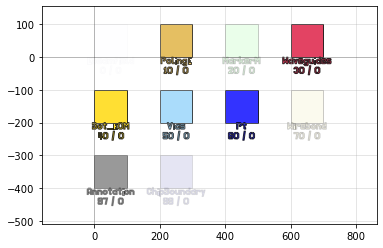

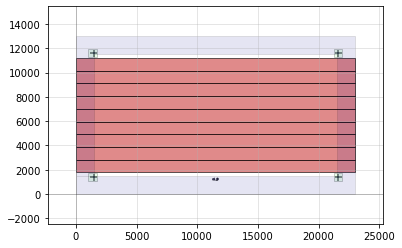

'mac_0.gds'

In [2]:
#Load process layers and save layer properties file for Klayout visualization.

ls = li.setup_layers()
P = pg.preview_layerset(ls)
qp(P)
# P.write_svg('Layers.svg')
pu.write_lyp('mac_0.lyp', layerset = ls)


#Set up the units

mm = 10**3
um = 1 
nm = 10 ** (-3)

# Global Chip Parameters
chip_width = 23*mm
chip_height = 13*mm
T = li.chip(size=(chip_width,chip_height), name='nl_0', text_size=150, keepout=1.5*mm)

X0 = 0
Y0 = 2300
ΔX = chip_width
ΔY = 1048

height = ΔY
for k in range(9):
    T << pg.rectangle( size=(chip_width, height), layer=98 ).move( [0,Y0+k*ΔY-height/2] )

qp(T)


#Waveguide dimensions

wg_width = 1.8*um
wg_width_oc = 2.3*um #outside cavity
wg_width_ic = 2.5*um #inside cavity
wg_width_m2m = 2.2*um #main to memory wg  NEED TO ADJUST THE RF EOM ANGLES FOR SPECIFIC CASE
wg_width_nif = 1.9*um
V_Groove_Spacing = 127*um;
xmargin =0.5*mm

wg_y_off = (height-V_Groove_Spacing*8)/2

#Bonding pad definitions
# Bonding Pads
pad = 50*um;
pad_g = 100*um;
elec = pad;
elec_m = 14*um; #middle_e_width
elec_s = 28*um; #side_e_width
pad_m = 1.5*mm

#RF pads
n_rf = 4 #number of RF pobres
spacing = 300
xoff = chip_width - (n_rf*2*spacing-pad) - pad_m 
yoff = height-pad #-pad/2

#Initial device setup
D = Device('mac')
D << pg.rectangle( size=(chip_width, height), layer=0 )

L = pg.text(text='MAC CHIP REV # 0', size=40, layer=30, justify='center')
D.add_ref(L).move((1.8*mm,yoff))
D.write_gds('mac_0.gds')

Length matching math and constants

In [3]:
#Lower arm (a and phi) path lengths
a_to_phi = 450.934996607*um
phi_len = 14*mm-0.169*um
phi_to_co = 15603.1440005*um

c_leg = 5.00436311264
#upper arm (b*c) path lengths
b_to_c = 314.158991993*um
c_len = c_leg+40+c_leg+14174.808+c_leg+40+c_leg
c_to_co = 15208.0394995 + 200
c_to_co_to_co = 15615.1189992 + 200

#length of first modulator
fm_len = 2340.44149484

#lo arm
lo_to_co = 33044.0455003

d_lo = fm_len + c_len + b_to_c + c_len + c_to_co_to_co - lo_to_co
d_a = b_to_c + c_len + c_to_co - a_to_phi - phi_len - phi_to_co
print("d_lo was "+ str(d_lo))
print("d_a was "+ str(d_a))

#final corrections made from DRC
d_a = d_a - (0.2669367994003551)
d_lo = d_lo + 5993.999827992804

d_lo was 13975.324890634118
d_a was -56.88605316344001


Alpha EOM: Decides how much power goes to LO and how much goes to MAC

In [4]:
im_gap = 0.8*um #Directional coupler gap
im_length = 1.5*mm #Length of entire device
coupler_l1 = 100*um #Directional coupler length
im_r = 50*um #This somehow controls the height of the device
im_angle = 45
elec_w = 50*um #Width of the metal electrodes
e_e_gap = 10*um #Gap between electrodes (waveguide in the middle)
via = elec_w*0.8

x_pos = 1.5*mm
y_pos = wg_y_off+3*V_Groove_Spacing + 40*um

x_base = x_pos
y_base = y_pos

mi_x = x_pos + im_length#save for later alignment of mirrored path
mi_y = y_pos

IM = Device('IM')
(IM,xl) = li.dcim(im_gap, im_length, coupler_l1, im_r, im_angle,elec_w,e_e_gap,via,wg_width_oc,V_Groove_Spacing)
D << IM.move([x_pos, y_pos])

#straight input wg top
P = Path()
P.append( pp.straight(length = x_pos+xmargin) )
P.movex(-xmargin)
P.movey(y_pos+V_Groove_Spacing)

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << P.extrude(X)

#straight input wg bottom
P = Path()
P.append( pp.straight(length = x_pos+xmargin) )
P.movex(-xmargin)
P.movey(y_pos)

#Some parameters for later that will help us connect this EOM to the next two
eomdc_1xs = x_pos
eomdc_1xl = xl*2+im_length
eomdc_1yb = y_pos
eomdc_1yt = y_pos+V_Groove_Spacing

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << P.extrude(X)
D.write_gds('mac_0.gds')



'mac_0.gds'

Alpha 2: Divies up power between mul and acc arms

In [5]:
im_angle = 45
elec_w = 50*um #Width of the metal electrodes
e_e_gap = 10*um #Gap between electrodes (waveguide in the middle)
via = elec_w*0.8

x_pos = 1.5*mm + im_length + 500*um + 265.423*um
y_pos = y_pos - 100*um -26.955879*um - 0.044*um

IM = Device('IM2')
(IM,xl) = li.dcim(im_gap, im_length, coupler_l1, im_r, im_angle,elec_w,e_e_gap,via,wg_width_oc,V_Groove_Spacing)
D << IM.move([x_pos, y_pos])

D.write_gds('mac_0.gds')


'mac_0.gds'

Two s-shaped sections for getting RF EOMs for A and B in the right spot

In [6]:
#Just kidding we don't need this
e_r = 50*um
e_a = 30
ml = 20*um

x_off = 1*mm + 265.424*um
y_off = 127.00378*um

xu = x_pos + 1*mm + x_off
yu = y_pos + y_off

xl = x_pos + 1*mm + x_off + 116.631*um
yl = y_pos - 127*um + y_off + 38.91*um - wg_width_oc

P = Path()
P.append( pp.euler(radius = e_r, angle = -e_a) )
P.append( pp.straight(length = ml) )
P.append( pp.euler(radius = e_r, angle = e_a) )

P_2 = Path()
P_2.append(P)
P_2.mirror()

P.movex(xu)
P.movey(yu)
P_2.movex(xl)
P_2.movey(yl)

#X = CrossSection()
#X.add(width = wg_width_oc, offset = 0, layer = 30)
#D << P.extrude(X)
#D << P_2.extrude(X)

#D.write_gds('mac_0.gds')

A RF EOM

In [7]:

# MMI Parameters
W = 2.3*um
L_tp = 5*um
W_tp = 2*um
L_mmi = 40*um
W_mmi = 8*um
Y_mmi = 4*um
middle_e_width = 14*um
off_chip = 0#?
length1 = 14*mm

e_e_gap_rf = 9*um

# MZI Parameters
radius = 100
#angle = 12.814353309

length0 = 4*mm
x_pos0 = xl + 50*um - 166.631*um
y_pos0 = yl + 50*um + 40.394376*um - 0.007986*um
dev = li.rfim(wg_width_oc, off_chip, W, L_tp, W_tp, L_mmi, W_mmi,Y_mmi,length1, radius,x_pos0,y_pos0,middle_e_width,e_e_gap_rf)
D << dev[0]
D.write_gds('mac_0.gds')

'mac_0.gds'

B RF EOM

In [8]:
x_pos1 = x_pos0
y_pos1 = y_pos0 - 127*um
dev = li.rfim(wg_width_m2m, off_chip, W, L_tp, W_tp, L_mmi, W_mmi,Y_mmi,length1, radius,x_pos1,y_pos1,middle_e_width,e_e_gap_rf)
D << dev[0]
D.write_gds('mac_0.gds')

'mac_0.gds'

Two 180 euler bends for the next set of EOMs

In [9]:
xu = x_pos1 + length1 + 270*um + 3.213*um
yu = y_pos0

xl = xu
yl = y_pos1
L1 = 136.77635*um


e_r = 50*um
e_a = 180
Pu = Path()
Pu.append( pp.euler(radius = e_r, angle = e_a) )
Pu.movex(xu)
Pu.movey(yu)
Pl = Path()
Pl.append( pp.euler(radius = e_r, angle = -e_a) )
Pl.append( pp.straight(length = L1))#Extra straight bit here to connect to next PM
Pl.movex(xl)
Pl.movey(yl)

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << Pu.extrude(X)
D << Pl.extrude(X)

D.write_gds('mac_0.gds')

'mac_0.gds'

C RF EOM

In [10]:
x_pos2 = x_pos0
y_pos2 = y_pos0 + 127*um + 10.683*um
dev = li.rfim(wg_width_oc, off_chip, W, L_tp, W_tp, L_mmi, W_mmi,Y_mmi,length1, radius,x_pos2,y_pos2,middle_e_width,e_e_gap_rf)
D << dev[0]
D.write_gds('mac_0.gds')

'mac_0.gds'

180 bend and straight waveguide for getting us to the a+b*c coupler from the a and b*c arms

In [11]:
e_r = 50*um
e_a = 180
e_s = 20#slope angle
e_c = 45#coupler angle
L1 = length1 + 374*um
L2 = 100*um
L3 = 25.558*um #Matching length for a and b*c arm coming to coupler
L_match = 100*um +(d_a/2)#Extra length for matching path lengths
sq2 = 1.41421356237 
#Lengths for transitioning to a + b*c coupler
L4 = 300*um + (89.614-im_gap)*sq2*0.5*um
L5 = 150*um
L12 = 100*um
L6 = 2*mm
L7 = 100*um

dL12 = -((259.849-127)/2)*sq2*um
L12 = L12 + dL12

d312 = ((206.66899-127)*sq2*um)

px = x_pos1
py = y_pos2
pyo = -(4*127)*um

P = Path();#upper path from bc to coupler
P.append( pp.straight(length = L7) )
P.append( pp.euler(radius = e_r, angle = e_a) )
P.append( pp.straight(length = L7) )
P.append( pp.straight(length = L1) )
P.append( pp.euler(radius = e_r, angle = e_c) )
P.append( pp.straight(length = L4) )
P.append( pp.euler(radius = e_r, angle = -e_c) )
L_c_c = P.length()#for later DRC
P.append( pp.straight(length = coupler_l1) )#Upper side of a+b*c
#bend away from coupler from upper output path to output
P.append( pp.euler(radius = e_r, angle = -e_c) )
P.append( pp.straight(length = L5) )
P.append( pp.euler(radius = e_r, angle = e_c) )
L_c_h = P.length()
P.append( pp.straight(length = coupler_l1) )#homodyne coupler
P.append( pp.euler(radius = e_r, angle = e_c) )
P.append( pp.straight(length = L12) )
P.append( pp.euler(radius = e_r, angle = -e_c) )
P.append( pp.straight(length = L6) )

P.mirror()

P.movex(px)
P.movey(py)

P3 = Path();#lower path with folded loop and length adjustment
P3.append( pp.euler(radius = e_r, angle = e_s) )
P3.append( pp.straight(length = L2) )
P3.append( pp.euler(radius = e_r, angle = -e_s) )
P3.append( pp.straight(length = L_match) )
P3.append( pp.euler(radius = e_r, angle = -e_a) )
P3.append( pp.straight(length = L_match) )
P3.append( pp.straight(length = L1) )
P3.append( pp.straight(length = L3) )
P3.append( pp.euler(radius = e_r, angle = -e_c) )
P3.append( pp.straight(length = L4) )
P3.append( pp.euler(radius = e_r, angle = e_c) )
L_phi_c = P3.length()#for later DRC
P3.append( pp.straight(length = coupler_l1) )#a + b*c coupler

#bend away from coupler from lower path to output
P3.append( pp.euler(radius = e_r, angle = e_c) )
P3.append( pp.straight(length = L5) )
P3.append( pp.euler(radius = e_r, angle = -e_c) )
P3.append( pp.straight(length = coupler_l1) )#dummy coupler section
P3.append( pp.euler(radius = e_r, angle = -e_c) )
P3.append( pp.straight(length = L12+d312) )
P3.append( pp.euler(radius = e_r, angle = e_c) )
P3.append( pp.straight(length = L6-79.669) )

P3.mirror()
P3.movex(px+136.606*um)
P3.movey(py + pyo + 103.334*um+wg_width_oc)

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << P.extrude(X)
D << P3.extrude(X)

P_c_to_out = P
P_phi_to_out = P3

D.write_gds('mac_0.gds')

'mac_0.gds'

A Phase RF EOM

In [12]:
x_pos3 = x_pos0 + 136.606*um
y_pos3 = y_pos0 - (2*127)*um - 10.683*um
dev = li.rfpm(wg_width_oc, length1, middle_e_width, e_e_gap_rf).move([x_pos3, y_pos3])
D << dev
D.write_gds('mac_0.gds')

'mac_0.gds'

LO DC PM waveguide

In [13]:
#need about 32mm in length total
e_s = 20#slope angle
pmx = x_base + im_length + 765.42382*um
pmy = y_base + 127*um

L1 = 1.8*mm
L2 = 3.6*mm
L3 = 18*mm
L4 = 3+((d_lo/1000)/2)*mm#Tuning length for matching with other arms
L5 = 200*um
L7 = 1*mm - (83.897*sq2*um) + 337.8378*um + ((im_gap+wg_width_oc)*um*sq2) - 1.283*um
L6 = 200*um + (109*sq2*um) + (83.897*sq2*um) - ((im_gap+wg_width_oc)*um*sq2)
L8 = 2*mm - 0.001*um


P = Path()
P.append(pp.straight(length = L1))
P.append( pp.euler(radius = e_r, angle = e_a) )
P.append(pp.straight(length = L2))
P.append( pp.euler(radius = e_r, angle = e_s) )#first squigle
P.append(pp.straight(length = L5))
P.append( pp.euler(radius = e_r, angle = -e_s) )
P.append( pp.euler(radius = e_r, angle = -e_a) )
P.append(pp.straight(length = L3))
P.append( pp.euler(radius = e_r, angle = e_a) )
P.append( pp.euler(radius = e_r, angle = e_s) )#second squigle
P.append(pp.straight(length = L5))
P.append( pp.euler(radius = e_r, angle = -e_s) )
P.append(pp.straight(length = L4))
P.append( pp.euler(radius = e_r, angle = -e_a) )
P.append(pp.straight(length = L4))

#bend down towards the homodyne output coupler
P.append(pp.straight(length = L7))
P.append( pp.euler(radius = e_r, angle = -45) )
P.append(pp.straight(length = L6))
P.append( pp.euler(radius = e_r, angle = 45) )
L_lo_h = P.length()
P.append( pp.straight(length = coupler_l1) )
P.append( pp.euler(radius = e_r, angle = 45) )
P.append(pp.straight(length = L12))
P.append( pp.euler(radius = e_r, angle = -45) )
P.append(pp.straight(length = L8))

P.movex(pmx)
P.movey(pmy)

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << P.extrude(X)
D.write_gds('mac_0.gds')

#Design rules check for the paths

L_bc = Pu.length()
L_aphi = Pl.length()


d_a = L_bc + c_len + L_c_c - L_aphi - phi_len - L_phi_c
d_lo = fm_len + c_len + L_bc + c_len + L_c_h - L_lo_h
print("d_a was " + str(d_a) + ", d_lo was " + str(d_lo))

d_a was -3.637978807091713e-12, d_lo was 0.0


C:\ProgramData\Anaconda3\lib\site-packages\phidl\device_layout.py:1318: UserWarning: [GDSPY] Polygons with more than 8190 are not supported by the official GDSII specification.  This GDSII file might not be compatible with all readers.
  lib.write_gds(filename, cells=all_cells)


Straight waveguide as an extra input to a/b*c DC IM

In [14]:
abc_y = 127*2*um + 56*um
abc_x = -0.5*mm

L1 = 3*mm + 1265.423*um
P = Path()
P.append(pp.straight(L1))
P.move([abc_x, abc_y])

X = CrossSection()
X.add(width = wg_width_oc, offset = 0, layer = 30)
D << P.extrude(X)
D.write_gds('mac_0.gds')

'mac_0.gds'

Metal for LO PM

In [15]:
U_h = 20*um
U_l = 20*mm - 2.46*mm

u_x = 700*um + 1.1*mm
u_y = 700*um + 60.088 + ((10-wg_width_oc)/2)
e_space = 10*um

#Upper electrode
D << pg.rectangle( size=(U_l, U_h), layer=40 ).move( [u_x, u_y] )
#Lower electrode
D << pg.rectangle( size=(U_l, U_h), layer=40 ).move( [u_x, u_y-e_space-(U_h)] )


D.write_gds('mac_0.gds')



'mac_0.gds'

Connections from modulators to wirebonding pads

In [16]:
#General connection definitions
g_w = elec_s
s_w = elec_m
run_l = 100*um

#Connections for C
c_x = x_pos2 + length1 + 120*um
c_y = y_pos2 + 16*um
c_len = 100*um
D << pg.rectangle( size=(c_len, g_w), layer=70 ).move( [c_x, c_y] )
D << pg.rectangle( size=(c_len+run_l, s_w), layer=70 ).move( [c_x, c_y-(g_w/2)-e_e_gap_rf] )
D << pg.rectangle( size=(c_len, g_w), layer=70 ).move( [c_x, c_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2)] )
#Bonding pad for signal
D << pg.rectangle( size=(100*um, 100*um), layer=70 ).move( [c_x+c_len+run_l, c_y-(g_w/2)-e_e_gap_rf] )

#Connections for B
b_x = x_pos1 + length1 + 120*um
b_y = y_pos1 + 16*um + 127*um
b_len = 100*um
D << pg.rectangle( size=(b_len, g_w), layer=70 ).move( [b_x, b_y] )
D << pg.rectangle( size=(b_len+run_l, s_w), layer=70 ).move( [b_x, b_y-(g_w/2)-e_e_gap_rf] )
D << pg.rectangle( size=(b_len, g_w), layer=70 ).move( [b_x, b_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2)] )
#Bonding pad for signal
D << pg.rectangle( size=(100*um, 100*um), layer=70 ).move( [b_x+b_len+run_l, b_y-(g_w/2)-e_e_gap_rf- 15*um] )


#Connections for A
a_x = x_pos1 + length1 + 120*um
a_y = y_pos1 + 16*um
a_len = 100*um
D << pg.rectangle( size=(a_len, g_w), layer=70 ).move( [a_x, a_y] )
D << pg.rectangle( size=(a_len+run_l, s_w), layer=70 ).move( [a_x, a_y-(g_w/2)-e_e_gap_rf] )
D << pg.rectangle( size=(a_len, g_w), layer=70 ).move( [a_x, a_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2)] )
#Bonding pad for signal
D << pg.rectangle( size=(100*um, 100*um), layer=70 ).move( [a_x+a_len+run_l, a_y-(g_w/2)-e_e_gap_rf- 45*um] )


#Connections for A_phase
a_x = x_pos1 + length1 + 120*um
a_y = y_pos1 + 16*um - 127*um - 21.683*um - 0.5*um
a_len = 100*um
D << pg.rectangle( size=(a_len, g_w), layer=70 ).move( [a_x, a_y] )
D << pg.rectangle( size=(a_len+run_l, s_w), layer=70 ).move( [a_x, a_y-(g_w/2)-e_e_gap_rf] )
D << pg.rectangle( size=(a_len, g_w), layer=70 ).move( [a_x, a_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2)] )
#Bonding pad for signal
D << pg.rectangle( size=(100*um, 100*um), layer=70 ).move( [a_x+a_len+run_l, a_y-(g_w/2)-e_e_gap_rf- 60*um] )




D.write_gds('mac_0.gds')

'mac_0.gds'

Mess of ground connections

In [17]:
g_run = 200*um
#BC and out to bus
D << pg.rectangle( size=(g_w, 70*um), layer=70 ).move( [c_x, c_y-150*um + 32*um] )
D << pg.rectangle( size=(c_len + g_run, g_w), layer=70 ).move( [c_x+c_len, c_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2)] )


#BA and out to bus
D << pg.rectangle( size=(g_w, 70*um), layer=70 ).move( [b_x, b_y-150*um + 32*um] )
D << pg.rectangle( size=((b_len*2) + g_run, g_w), layer=70 ).move( [b_x, b_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2) - 20*um] )

#APhi and out to bus
D << pg.rectangle( size=(g_w, 70*um), layer=70 ).move( [a_x, a_y-150*um + 32*um + 140*um] )
D << pg.rectangle( size=((a_len*2) + g_run, g_w), layer=70 ).move( [a_x, a_y-(g_w/2)-e_e_gap_rf-(s_w)-e_e_gap_rf-(g_w/2) + 100*um] )

D.write_gds('mac_0.gds')


'mac_0.gds'

LO EOM routes to bus

In [18]:
#vias first
v1_x = u_x+U_l-13*um
v1_y = u_y + 1*um
v2_x = u_x+U_l-13*um
v2_y = u_y + 1*um -e_space-(U_h)
D << pg.rectangle( size=(13*um, U_h-2*um), layer=50 ).move( [v1_x, v1_y] )
D << pg.rectangle( size=(13*um, U_h-2*um), layer=50 ).move( [v2_x, v2_y] )
D << (pg.rectangle( size=(15*um, 300*um-163*um), layer=70 ).rotate(180)).move( [v2_x+14*um, v2_y+19*um] )
D << (pg.rectangle( size=(15*um, 0.85*mm), layer=70 ).rotate(270)).move( [v2_x+14*um-15*um, v2_y+19*um-300*um+163*um] )
sq_d = 100*um
sq_d2 = 500*um-185*um
sq_x_o =  0.9*mm+24.847*um
D << (pg.rectangle( size=(15*um, sq_d), layer=70 ).rotate(180)).move( [v2_x+14*um-15*um+sq_x_o, v2_y+19*um-300*um+163*um+sq_d] )
D << (pg.rectangle( size=(15*um, sq_d2), layer=70 ).rotate(270)).move( [v2_x+14*um-15*um+sq_x_o-15*um, v2_y+19*um-300*um+163*um+2*sq_d-sq_d] )
#D << (pg.rectangle( size=(15*um, sq_d), layer=70 ).rotate(180)).move( [v2_x+14*um-15*um + sq_d+sq_x_o, v2_y+19*um-300*um+163*um+2*sq_d] )
#Signal connection and pad
lo_l = 1*mm+23.847*um
D << (pg.rectangle( size=(20*um, lo_l), layer=70 ).rotate(270)).move( [v1_x, v1_y+19*um] )
D << (pg.rectangle( size=(100*um, 0.1*mm), layer=70 ).rotate(0)).move( [v1_x+lo_l, v1_y+19*um-40*um] )

D.write_gds('mac_0.gds')

#Tie bottom pm electrode to ground

'mac_0.gds'

Busses for routing modulators to edge of chip

In [ ]:
#Coordinate reference for all connections. 
x_p = 21.0*mm

y_p = 0

#electrode size and spacing
x_s = 100*um
y_s = 1*mm
x_space = 50*um

#First one is ground
for i in range(0, 8):
    D << pg.rectangle( size=(x_s, y_s), layer=70 ).move( [x_p + (i*(x_s+x_space)), y_p] )

D.write_gds('mac_0.gds')